# Mini-project 1: Tic-Tac-Toe
Clément DAUVILLIERS - Florian VINCENT

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
from math import log
from tic_env import TictactoeEnv, OptimalPlayer

## Useful functions

In [81]:
def windowed_avg(arr, window_len=250):
    """
    Computes the average over successive windows of an array.
    arr must be a 1D array whose length is a multiple of the
    window length.
    """
    return arr.reshape((window_len, -1)).mean(axis=0)

# 2. Q-Learning

### Player class
The following class will be used as base for the QLearning and DQN player classes.

In [56]:
class Player:
    """
    Base class for both types of players (QLearning, DQN).
    """
    def __init__(self, player='X', epsilon=0.05, seed=666):
        self.player = player
        self.epsilon = epsilon
        
        # RNG for the epsilon-gredy policy
        self.rng_ = np.random.default_rng(seed=seed)
    
    def act(self, grid):
        """
        Selects an action to perform based on the current
        grid state and the player's policy.
        """
        raise NotImplementedError("Call from abstract class")
        
    def set_player(self, player):
        self.player = player
    
    @staticmethod
    def empty(grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail
        
    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)

        return avail[self.rng_.integers(0, len(avail))]

### QLPlayer class
The following class implements the QLearning player.

In [57]:
class QLPlayer(Player):
    """
    Implements a player that learns using the QLearning algorithm.
    """
    def __init__(self, player='X', lr=0.05, discount=0.99, epsilon=0.05, seed=666):
        super().__init__(player, epsilon, seed)
        self.lr = lr
        self.discount = discount
        self.epsilon = epsilon
        
        # Q-values grid
        # 3^9 = 19683 states and 9 actions
        self.qvalues = np.zeros((19683, 9))
        
        # Memory
        self.last_action = None
        self.last_state = None
        
    def act(self, grid):
        # Epsilon-greedy choice
        if self.rng_.random() < self.epsilon:
            return self.randomMove(grid)
        # Retrieves the list of possible actions and converts them
        # from cell positions to integer indexes
        avail_actions = QLPlayer.positions_to_ints(Player.empty(grid))
        # Ranks ALL actions according to their Qvalues in the current
        # state
        state = QLPlayer.state_to_int(grid)
        actions_ranks = np.argsort(self.qvalues[state])[::-1]
        # Browses all actions in order of their qvalue rank, until
        # finding one that is available
        for action in actions_ranks:
            if action in avail_actions:
                # Memorizes the action and the current state for the learning
                # phase
                self.last_action, self.last_state = action, state
                return int(action)
    
    def learn(self, reward, new_grid):
        """
        Updates the Qvalues based on the last (S, A) pair and
        the received reward and the new state.
        """
        # Computes the optimal Qvalue in the new state max Q(s', a)
        new_state = QLPlayer.state_to_int(new_grid)
        new_state_qval = np.max(self.qvalues[new_state])
        # QValue that needs to be updated Q(s, a)
        current_qval = self.qvalues[self.last_state, self.last_action]
        
        self.qvalues[self.last_state, self.last_action] += self.lr * (reward + self.discount * new_state_qval - current_qval)
    
    @staticmethod
    def position_to_int(position):
        """
        (row col) -> row*3 + col
        """
        return position[0] * 3 + position[1]
    
    @staticmethod
    def positions_to_ints(positions):
        """
        Given a list of cells [(a, b), (c, d), ..],
        returns the list of the corresponding indexes.
        """
        return [QLPlayer.position_to_int(cell) for cell in positions]

    @staticmethod
    def state_to_int(grid):
        """
        Converts a grid state to the index of its
        row in the lookup table.
        """
        # Converts the grid values from -1, 0, 1 to 0, 1, 2
        # Then takes the sum of (value of cell i  * 3^i) for every cell in the
        # grid.
        return int((np.ravel(grid) + 1) @ np.array([3 ** i for i in range(9)]))
    
    @staticmethod
    def int_to_state(state_int):
        """
        Converts the index of row in the qvalues table to
        its corresponding state.
        """
        return np.array([
            (state_int % (3 ** (i + 1))) // (3 ** i)
            for i in range(9)
        ]).reshape((3, 3)) - 1

## 2.1 Learning from experts

### Question 1

In [50]:
def play_games(learning_player, benchmark_player, nb_games=20000, turns_swap="switch", seed=666):
    """
    Plays a given number of games between two players, and returns the rewards.
    --learning_player: Player object implementing act() and learn();
    --benchmark_player: Player object implementing act();
    --nb_games: How many games should be played;
    --turns_swap: str, either "switch" to switch turns after every game, or "random".
    --seed: random seed.
    """
    turns = np.array(['X','O'])
    learning_player.set_player(turns[0])
    benchmark_player.set_player(turns[1])
    rewards = []
    env = TictactoeEnv()
    
    for game in trange(nb_games):
        # Sets up the environment for the game
        env.reset()
        grid, _, _ = env.observe()
        if turns_swap == "switch":
            turns = turns[[-1, 0]]
        else:
            turns = np.random.shuffle(turns)
        
        while True:
            # Action step
            if env.current_player == learning_player.player:
                move = learning_player.act(grid)
            else:
                move = benchmark_player.act(grid)

            grid, end, winner = env.step(move, print_grid=False)
            reward = env.reward(learning_player.player)

            # Learning step
            learning_player.learn(reward, grid)

            if end:
                env.reset()
                rewards.append(reward)
                break
    
    return np.array(rewards)

In [102]:
qlplayer = QLPlayer(epsilon=0.05)
semi_random_player = OptimalPlayer(0.5)

In [103]:
rewards_21 = play_games(qlplayer, semi_random_player)

  0%|          | 0/20000 [00:00<?, ?it/s]

(-1.0, 1.0)

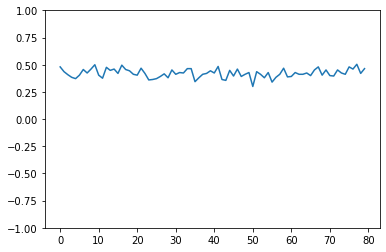

In [104]:
plt.plot(windowed_avg(rewards_21))
plt.ylim(-1, 1)

(-1.0, 1.0)

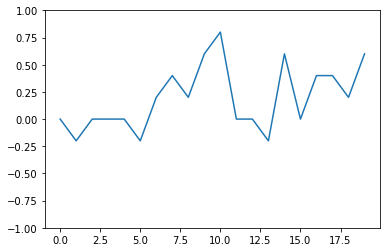

In [118]:
plt.plot(windowed_avg(rewards_21[:100], window_len=5))
plt.ylim(-1, 1)